## UNET Model 

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

## Set up the metric

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Train the model 

In [29]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from model import build_unet
from metrics import dice_coef, iou

H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(dataset_path, split=0.2):
    images = sorted(glob(os.path.join(dataset_path, "ISIC2016_Task1_Training_Input", "*.jpg")))
    masks = sorted(glob(os.path.join(dataset_path, "ISIC2016_Task1_Training_GroundTruth", "*.png")))

    test_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=test_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x                                ## (256, 256, 3)

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (H, W)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)                    ## (256, 256)
    x = np.expand_dims(x, axis=-1)              ## (256, 256, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving data """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4 ## (0.0001)
    num_epoch = 5
    model_path = "files/model.h5"
    csv_path = "files/data.csv"

    """ Dataset : 60/20/20 """
    dataset_path = "isic-challenge-2016/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1

    if len(valid_x) % batch_size != 0:
        valid_steps += 1

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr), metrics=metrics)
    model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
    )

Train: 540 - 540
Valid: 180 - 180
Test: 180 - 180
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )         

                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_8[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_181 (Activation)    (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_181[0][0]']         
                                )                                                                 
          

                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 12  0           ['conv2d_transpose_3[0][0]',     
                                8)                                'activation_174[0][0]']         
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

In [52]:
train_x

['isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000102.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0010101.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0010104.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0011357.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000409.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000224.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0010473.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000278.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000263.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0010593.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0010093.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000032.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_0000152.jpg',
 'isic-challenge-2016/ISIC2016_Task1_Training_Input\\ISIC_000471

In [5]:
import warnings
warnings.filterwarnings('always')

## Make the evaluation

In [7]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from metrics import dice_loss, dice_coef, iou
from train import load_data, create_dir

H = 256
W = 256

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x                                ## (1, 256, 256, 3)


def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (H, W)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)                    ## (256, 256)
    return ori_x, x

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)  ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving results """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model("files/model.h5")

    """ Load the test data """
    dataset_path = "isic-challenge-2016/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Exctracting the image name """
        name = x.split("/")[-1]

        """ Read the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        """ Predicting the mask """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask """
        #print(name)
        save_image_path = f"results/{name}"
        save_results(ori_x, ori_y, y_pred, save_image_path)
        #cv2.imwrite("1.jpg", y_pred)
        #break
        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary",zero_division= 1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ mean metrics values """
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns = ["Image Name", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:25<00:00,  7.60it/s]


Accuracy: 0.81979
F1: 0.41586
Jaccard: 0.33860
Recall: 0.35866
Precision: 0.95806


In [20]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, concatenate, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.layers.core import SpatialDropout2D
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import sklearn.metrics as metrics
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

# SegNet

In [41]:
import re
import glob
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

filelist_trainx_ph2 = sorted(glob.glob('isic-challenge-2016/ISIC2016_Task1_Training_Input/*.jpg'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('isic-challenge-2016/ISIC2016_Task1_Training_GroundTruth/*.png'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

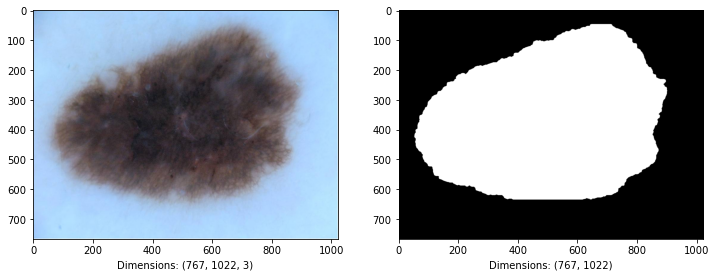

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[0]).shape))
plt.show()

In [45]:
def resize(filename, size = (256,256)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx_ph2)):
    X_train_ph2_resized.append(resize(filelist_trainx_ph2[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy_ph2[i]))    

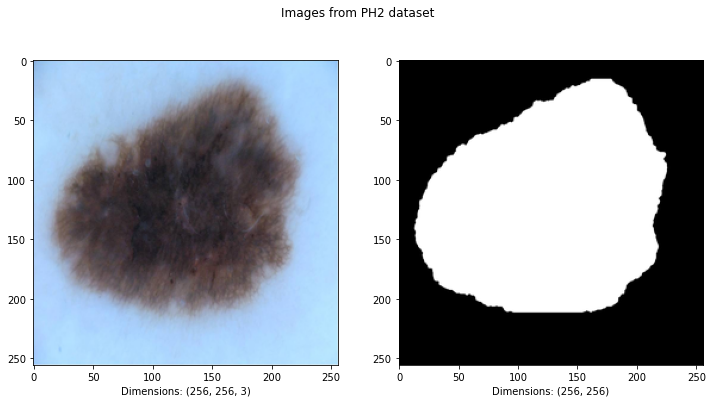

In [46]:
plt.figure(figsize=(12,6))
plt.suptitle("Images from PH2 dataset")
plt.subplot(1,2,1)
plt.imshow(X_train_ph2_resized[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2_resized[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2_resized[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2_resized[0]).shape))
plt.show()

In [54]:
x_train, x_val = train_test_split(X_train_ph2, test_size = 0.2, random_state = 42)
y_train, y_val = train_test_split(Y_train_ph2, test_size = 0.2, random_state = 42)

x_train, x_test = train_test_split(x_train, test_size = 0.2, random_state = 42)
y_train, y_test = train_test_split(y_train, test_size = 0.2, random_state = 42)




In [63]:
type(torchvision.transforms.functional.to_tensor(x_train))

ValueError: pic should be 2/3 dimensional. Got 1 dimensions.

In [57]:

def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((256,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()])
    model.summary()
    hist = model.fit(torchvision.transforms.functional.to_tensor(x_train), torchvision.transforms.functional.to_tensor(y_train), epochs= epochs_num, batch_size= 16, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [59]:
import torchvision

In [60]:
model_2, hist_2 = segnet(100, 'segnet.h5')

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_295 (Activation)  (None, 256, 256, 64)     0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_296 (Activation)  (None, 256, 256, 64)     0  

 g2D)                                                            
                                                                 
 deconv4 (Conv2DTranspose)   (None, 32, 32, 512)       2359808   
                                                                 
 bn17 (BatchNormalization)   (None, 32, 32, 512)       2048      
                                                                 
 activation_311 (Activation)  (None, 32, 32, 512)      0         
                                                                 
 deconv5 (Conv2DTranspose)   (None, 32, 32, 512)       2359808   
                                                                 
 bn18 (BatchNormalization)   (None, 32, 32, 512)       2048      
                                                                 
 activation_312 (Activation)  (None, 32, 32, 512)      0         
                                                                 
 deconv6 (Conv2DTranspose)   (None, 32, 32, 256)       1179904   
          

ValueError: pic should be 2/3 dimensional. Got 1 dimensions.